In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
from hybridpy.learning import dynamicprogramming, ensemblepredictor
from hybridpy.dataset import triploader
import osmapping
import glob

In [4]:
dname = '/Users/astyler/projects/ChargeCarData/illah/'
trips = []
fnames = glob.glob(dname+'*.csv')
for fname in fnames:
    trips.append(triploader.load(fname))
    
len(trips)

/Users/astyler/anaconda/lib/python2.7/site-packages/hybridpy/dataset/triploader.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  trip.Acceleration[0] = 0


575

In [5]:
trips[4].head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,Heading,Gradient
0,40.450752,-79.929198,247.734948,2.98,13.28,13.275005,0.000000,3342.2758,0.0000,1000,1267506595000,0,2.977927,0.001656
1,40.450771,-79.929353,247.758603,2.96,10.00,11.021376,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,2.936109,0.001656
2,40.450788,-79.929469,247.780730,2.96,10.00,9.175370,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,2.891831,0.002012
3,40.450804,-79.929585,247.801039,2.90,6.74,6.543060,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,2.846653,0.001850
4,40.450819,-79.929663,247.819220,2.70,2.74,3.169773,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,2.808650,0.002329


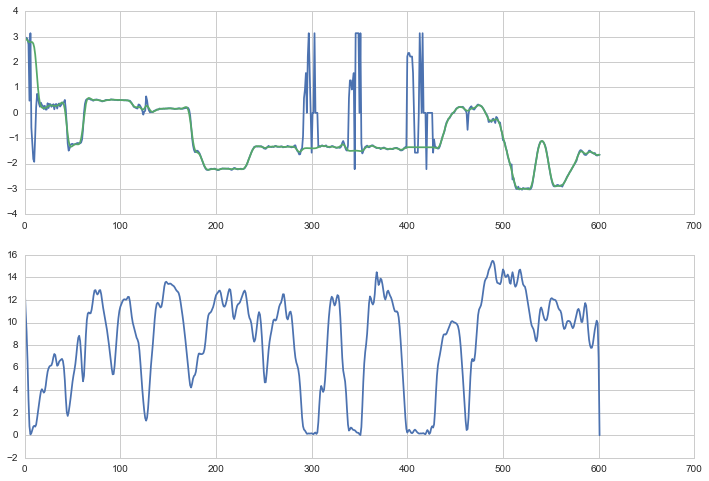

In [6]:
plt.figure(figsize=(12,8))
ax = plt.subplot(211)
ax.plot(trips[4].Bearing)
ax.plot(trips[4].Heading)

ax = plt.subplot(212)
ax.plot(trips[4].Speed)


In [7]:
buffr = 0.01
mins=[(min(trip.Longitude) -buffr,min(trip.Latitude)-buffr) for trip in trips]
maxs=[(max(trip.Longitude) + buffr,max(trip.Latitude)+buffr) for trip in trips]

ll = map(min,zip(*mins))
ur = map(max,zip(*maxs))
print ll
print ur


[-80.274581999999995, 40.273409999999998]
[-79.510327000000004, 40.505786999999998]


In [8]:
ll = [-80.0, 40.40]
ur = [-79.87, 40.48]
mymap = osmapping.MLMap(ll,ur)

In [9]:
for trip in trips:
    trip['x'], trip['y'] = mymap.convert_coordinates(trip[['Longitude','Latitude']].values).T

In [10]:
mymap.load_shape_file('./shapefiles/pittsburgh/line.shp')
mymap.load_shape_file('./shapefiles/pittsburgh/polygon.shp')

In [11]:
mymap.clear_selected_shapes()

road = {'edgecolor':'white','lw':3, 'facecolor':'none','zorder':6};

mymap.select_shape('highway','motorway',**road)
mymap.select_shape('highway','trunk',**road)
mymap.select_shape('highway','primary',**road)
mymap.select_shape('highway','secondary',**road)
mymap.select_shape('highway','tertiary',**road)
mymap.select_shape('highway','residential',**road)
mymap.select_shape('leisure','park',facecolor='#BBDDBB',edgecolor='none',zorder=4)
mymap.select_shape('waterway','riverbank',facecolor='#CCCCEE', edgecolor='none', zorder=5)

mymap.select_shape('natural','water',facecolor='#CCCCEE', edgecolor='none', zorder=5)

In [12]:
training = trips[0:4]+trips[5:]
test = trips[4]

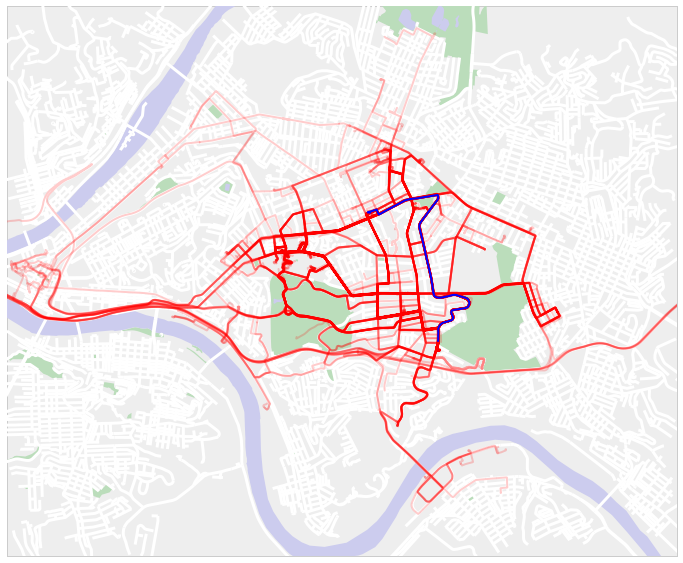

In [13]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (idx,trip) in enumerate(training):
    ax.plot(trip.x, trip.y, lw=2, alpha=0.2, c='red', zorder=99)
    
ax.plot(test.x, test.y, lw=2, alpha=1, c='blue', zorder=100)

In [13]:
test.head()

,Latitude,Longitude,Elevation,Bearing,PlanarDistance,Speed,Acceleration,Power,TotalEnergyUsed,PeriodMS,Time,ElapsedSeconds,Heading,Gradient,x,y
0,40.450752,-79.929198,247.734948,2.98,13.28,13.275005,0.000000,3342.2758,0.0000,1000,1267506595000,0,2.977927,0.001656,8315.788601,7858.642763
1,40.450771,-79.929353,247.758603,2.96,10.00,11.021376,-2.253629,-16710.7009,0.9284,1000,1267506596000,1,2.936109,0.001656,8298.534080,7861.411421
2,40.450788,-79.929469,247.780730,2.96,10.00,9.175370,-1.846006,1862.2865,-3.7135,1000,1267506597000,2,2.891831,0.002012,8285.621019,7863.888641
3,40.450804,-79.929585,247.801039,2.90,6.74,6.543060,-2.632310,-11461.9095,-3.1961,1000,1267506598000,3,2.846653,0.001850,8272.707958,7866.220143
4,40.450819,-79.929663,247.819220,2.70,2.74,3.169773,-3.373287,-5999.9652,-6.3800,1000,1267506599000,4,2.808650,0.002329,8264.025038,7868.405927


In [30]:
features = ['Latitude', 'Longitude', 'Heading', 'Speed', 'Acceleration', 'Power', 'TotalEnergyUsed']
feature_weights =  [1,1,1e1,0,0,0,0]
ep = ensemblepredictor.EnsemblePredictor(training, features=features, feature_weights=feature_weights)

In [33]:
import math

In [44]:
import numpy as np

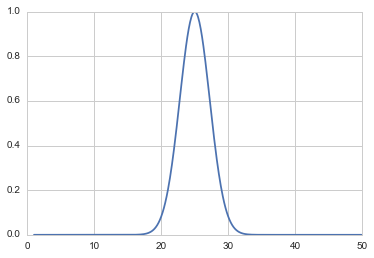

In [46]:
x=np.arange(1,50,0.1)
m=25
sigma=5.0
plt.plot(x, [math.exp(-(xv-m)**2/(2*sigma)) for xv in x])

In [52]:
def norm(dist, sigma):
    return math.exp(-(dist)**2/(2*sigma))

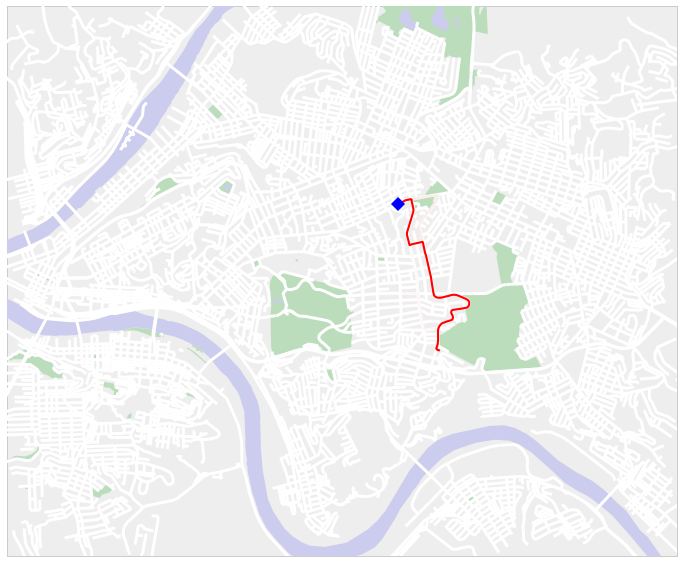

In [62]:
index = 100
results = [(norm(r[0], 1e-4),r[1]) for r in ep.predict(test.iloc[index])]
best_weight = max(results)[0]
results = [(w/best_weight, i) for (w,i) in results]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')

for (r, trip) in zip(results, training):
    idx = r[1]
    ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=2, alpha=r[0], c='red', zorder=99)
    #ax.plot(trip.x.iloc[idx], trip.y.iloc[idx], 'gD', alpha=1, markersize=20*r[0], zorder=100)

ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)


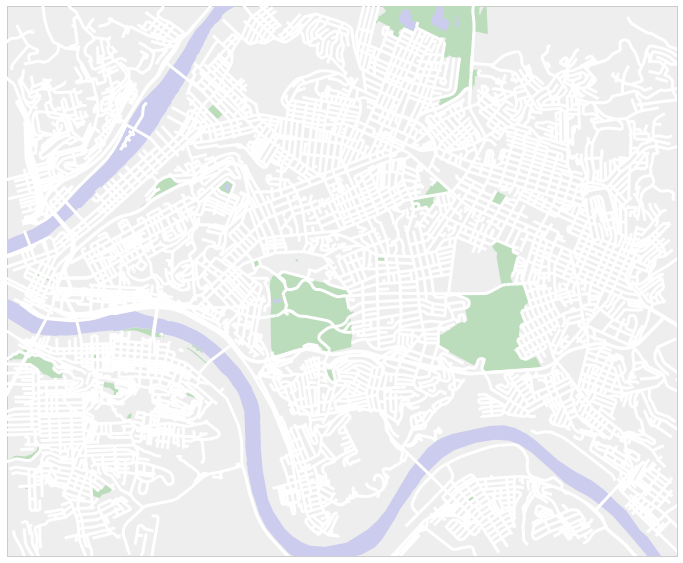

In [65]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
mymap.draw_map(ax, map_fill='#eeeeee')
weights = []  
for index in range(0,len(test),5):
    results = [(norm(r[0], 1e-3),r[1]) for r in ep.predict(test.iloc[index])]
    best_weight = max(results)[0]
    #weights.append(best_weight)
    #best_weight = 20
    results = [(w/best_weight, i) for (w,i) in results]

    lines = []
    for (r, trip) in zip(results, training):
        idx = r[1]
        line = ax.plot(trip.x.iloc[idx:], trip.y.iloc[idx:], lw=4, alpha=r[0], c='red', zorder=99)
        lines.append(line[0])
        
    pt = ax.plot(test.x.iloc[index], test.y.iloc[index], 'bD', markersize=10, zorder=101)[0]
    plt.savefig('video/aframe'+str(index)+'.jpg')
    
    
    for line in lines:
        line.remove()
        del line
    pt.remove()

In [ ]:
weights